To Do:

SVR
Gaussian Process
Polynomial Regression
NN
Random Forest for Regression

In [1]:
# Import Packages I will need
from lex_processing import * 
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# To show plots in notebook
%matplotlib inline  

from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.style.use('classic')

from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy import stats

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from collections import Counter

In [10]:
# Path is where the data I want to process is.
# For Mac
pathReagan = '/Users/Joe/dropbox/Data/Edited Data/Presidents Data/ReaganSpeeches/'
pathBush = '/Users/Joe/dropbox/Data/Edited Data/Presidents Data/BushSpeeches/'
pathTrump = '/Users/Joe/dropbox/Data/Edited Data/Presidents Data/TrumpSpeeches/'
# For Linux
#pathReagan = '/home/CAMPUS/alcantaj/Dropbox/Data/Edited Data/Presidents Data/ReaganSpeeches/'
#pathBush = '/home/CAMPUS/alcantaj/Dropbox/Data/Edited Data/Presidents Data/BushSpeeches/'
#pathTrump = '/home/CAMPUS/alcantaj/Dropbox/Data/Edited Data/Presidents Data/TrumpSpeeches/'

In [11]:
dfReagan = pd.DataFrame()
dfBush = pd.DataFrame()
dfTrump = pd.DataFrame()

In [12]:
for filename in os.listdir(pathReagan):
    if filename.endswith('txt'):
        f = open(pathReagan + filename)
        raw = f.read()
        # Clear raw of punctuation and tokenize for word counts.
        wordsNoPunct = strip_punctuation(raw)
        #hesitations = wordsNoPunct.count('—')
        wordsNoPunct.replace("—", ' ')
        wordsNoPunct = word_tokenize(wordsNoPunct)
        words = word_tokenize(raw)
        # Word Counts for certain words
        c = Counter(words)
        Fillers = c['well'] + c['so'] + c['basically'] + c['actually'] + c['literally'] + c['um'] + c['ah']
        NSNouns = c['something'] + c['anything'] + c['thing']
        LIVerbs = c['be'] + c['come'] + c['do'] + c['get'] + c['give'] + c['go'] + c['have'] + c['know'] + c['look']
        + c['make'] + c['see'] + c['tell'] + c['think'] + c['want']
        
        sents = sent_tokenize(raw)
        processed = preprocess(raw)
        lex = lexical_diversity(wordsNoPunct)
        mls = meanLengthSentence(processed)
        wordDict = wordCount(processed)
        thetuple = {'Filename': filename, 'TTR': lex,
                    'WordCount':len(wordsNoPunct), 
                    'UniqueWords':len(set(wordsNoPunct)), 
                    'MLU': mls, 'Fillers': Fillers,
                   'NSNouns': NSNouns, 'LIVerbs': LIVerbs}
        finalDict = {**thetuple, **wordDict}
        dfReagan = dfReagan.append(finalDict, ignore_index = True)

In [13]:
for filename in os.listdir(pathBush):
    if filename.endswith('txt'):
        f = open(pathBush + filename)
        raw = f.read()
        # Clear raw of punctuation and tokenize for word counts.
        wordsNoPunct = strip_punctuation(raw)
        #hesitations = wordsNoPunct.count('-')
        wordsNoPunct.replace("-", ' ')
        wordsNoPunct = word_tokenize(wordsNoPunct)
        
        words = word_tokenize(raw)
        # Word Counts for certain words
        c = Counter(words)
        Fillers = c['well'] + c['so'] + c['basically'] + c['actually'] + c['literally'] + c['um'] + c['ah']
        NSNouns = c['something'] + c['anything'] + c['thing']
        LIVerbs = c['be'] + c['come'] + c['do'] + c['get'] + c['give'] + c['go'] + c['have'] + c['know'] + c['look']
        + c['make'] + c['see'] + c['tell'] + c['think'] + c['want']
        
        sents = sent_tokenize(raw)
        processed = preprocess(raw)
        lex = lexical_diversity(wordsNoPunct)
        mls = meanLengthSentence(processed)
        wordDict = wordCount(processed)
        thetuple = {'Filename': filename, 'TTR': lex,
                    'WordCount':len(wordsNoPunct), 
                    'UniqueWords':len(set(wordsNoPunct)), 
                    'MLU': mls, 'Fillers': Fillers,
                   'NSNouns': NSNouns, 'LIVerbs': LIVerbs}
        finalDict = {**thetuple, **wordDict}
        dfBush = dfBush.append(finalDict, ignore_index = True)

In [14]:
for filename in os.listdir(pathTrump):
    if filename.endswith('txt'):
        f = open(pathTrump + filename)
        raw = f.read()
        # Clear raw of punctuation and tokenize for word counts.
        wordsNoPunct = strip_punctuation(raw)
        #hesitations = wordsNoPunct.count('-')
        wordsNoPunct.replace("-", ' ')
        wordsNoPunct = word_tokenize(wordsNoPunct)
        
        words = word_tokenize(raw)
        # Word Counts for certain words
        c = Counter(words)
        Fillers = c['well'] + c['so'] + c['basically'] + c['actually'] + c['literally'] + c['um'] + c['ah']
        NSNouns = c['something'] + c['anything'] + c['thing']
        LIVerbs = c['be'] + c['come'] + c['do'] + c['get'] + c['give'] + c['go'] + c['have'] + c['know'] + c['look']
        + c['make'] + c['see'] + c['tell'] + c['think'] + c['want']
        
        sents = sent_tokenize(raw)
        processed = preprocess(raw)
        lex = lexical_diversity(wordsNoPunct)
        mls = meanLengthSentence(processed)
        wordDict = wordCount(processed)
        thetuple = {'Filename': filename, 'TTR': lex,
                    'WordCount':len(wordsNoPunct), 
                    'UniqueWords':len(set(wordsNoPunct)), 
                    'MLU': mls, 'Fillers': Fillers,
                   'NSNouns': NSNouns, 'LIVerbs': LIVerbs}
        finalDict = {**thetuple, **wordDict}
        dfTrump = dfTrump.append(finalDict, ignore_index = True)

In [15]:
# Rearranging Columns
inserted_cols = ['Filename', 'TTR','WordCount', 'UniqueWords', 'MLU', 'Fillers', 'NSNouns', 'LIVerbs']
cols = ([col for col in inserted_cols if col in dfReagan] 
        + [col for col in dfReagan if col not in inserted_cols])
dfReagan = dfReagan[cols]

In [16]:
# Rearranging Columns
inserted_cols = ['Filename', 'TTR','WordCount', 'UniqueWords', 'MLU', 'Fillers', 'NSNouns', 'LIVerbs']
cols = ([col for col in inserted_cols if col in dfBush] 
        + [col for col in dfBush if col not in inserted_cols])
dfBush = dfBush[cols]

In [17]:
# Rearranging Columns
inserted_cols = ['Filename', 'TTR','WordCount', 'UniqueWords', 'MLU', 'Fillers', 'NSNouns', 'LIVerbs']
cols = ([col for col in inserted_cols if col in dfTrump] 
        + [col for col in dfTrump if col not in inserted_cols])
dfTrump = dfTrump[cols]

In [18]:
# Fill NA's with 0s as in this dataset, NAN represent the feature NOT occuring in a particular document.
dfReagan = dfReagan.fillna(0)
dfBush = dfBush.fillna(0)
dfTrump = dfTrump.fillna(0)

In [19]:
dfReagan.to_csv('testReagan.csv')
dfBush.to_csv('testBush.csv')
dfTrump.to_csv('testTrump.csv')

In [22]:
# For Mac
testpath = '/Users/Joe/Documents/PhD/Jupyter Notebooks/'
# For Linux
#testpath = '/home/CAMPUS/alcantaj/Documents/PhD/Jupyter Notebooks/'

In [23]:
a = pd.read_csv(testpath + "dates.csv")
b = pd.read_csv(testpath + "testReagan.csv")

c = pd.read_csv(testpath + "dates2.csv")
d = pd.read_csv(testpath + "testBush.csv")

e = pd.read_csv(testpath + "dates3.csv")
f = pd.read_csv(testpath + "testTrump.csv")

In [24]:
a['JDate'] = [datetime.datetime.strptime(x, '%d/%m/%Y') for x in a['Date']]
c['JDate'] = [datetime.datetime.strptime(x, '%d/%m/%Y') for x in c['Date']]
e['JDate'] = [datetime.datetime.strptime(x, '%d/%m/%Y') for x in e['Date']]

In [25]:
a['Julian'] = [get_julian_datetime(x) for x in a['JDate']]
c['Julian'] = [get_julian_datetime(x) for x in c['JDate']]
e['Julian'] = [get_julian_datetime(x) for x in e['JDate']]

In [26]:
mergedRR = a.merge(b, on='Filename')
mergedGWHB = c.merge(d, on='Filename')
mergedDJT = e.merge(f, on='Filename')

In [27]:
mergedRR = mergedRR.sort_values(by=['JDate'])
mergedGWHB = mergedGWHB.sort_values(by=['JDate'])
mergedDJT = mergedDJT.sort_values(by=['JDate'])

In [28]:
# Create new labels (Index is in order of article date)
mergedRR = mergedRR.reset_index()
mergedRR['index'] = mergedRR.index
mergedGWHB = mergedGWHB.reset_index()
mergedGWHB['index'] = mergedGWHB.index
mergedDJT = mergedDJT.reset_index()
mergedDJT['index'] = mergedDJT.index

In [29]:
# Dropping Redundant Columns
mergedRR = mergedRR.drop(['Unnamed: 0'], axis=1)
mergedGWHB = mergedGWHB.drop(['Unnamed: 0'], axis=1)
mergedDJT = mergedDJT.drop(['Unnamed: 0'], axis=1)

In [30]:
# To avoid confusion, rename merged to df
dfRR = mergedRR
dfGWHB = mergedGWHB
dfDJT = mergedDJT

In [31]:
# Add Target Variable
yRR = dfRR['index']
yGWHB = dfGWHB['index']
yDJT = dfDJT['index']

#yRR = dfRR['Julian']
#yGWHB = dfGWHB['Julian']

In [32]:
# Calculate some new aggregate columns
dfRR['Nouns'] = dfRR['NN'] + dfRR['NNS']+ dfRR['NNP'] + dfRR['NNPS']
dfRR['Nouns/100'] = dfRR['Nouns'] / 100
dfRR['NounsNormalised'] = dfRR['Nouns'] / dfRR['WordCount']
dfRR['Adjectives'] = dfRR['JJ'] + dfRR['JJR'] + dfRR['JJS']
dfRR['Adjectives/100'] = dfRR['Adjectives'] / 100
dfRR['AdjectivesNormalised'] = dfRR['Adjectives'] / dfRR['WordCount']
dfRR['Adverbs'] = dfRR['RB'] + dfRR['RBR'] + dfRR['RBS']
dfRR['Adverbs/100'] = dfRR['Adverbs'] / 100
dfRR['AdverbsNormalised'] = dfRR['Adverbs'] / dfRR['WordCount']
dfRR['Verbs'] = dfRR['VB'] + dfRR['VBD'] + dfRR['VBG'] + dfRR['VBN'] + dfRR['VBP'] + dfRR['VBZ']
dfRR['Verbs/100'] = dfRR['Verbs'] / 100
dfRR['VerbsNormalised'] = dfRR['Verbs'] / dfRR['WordCount']
dfRR['Pronouns'] = dfRR['PRP'] + dfRR['PRP$']
dfRR['PronounsNormalised'] = dfRR['Pronouns'] / dfRR['WordCount']

In [33]:
# Calculate some new aggregate columns
dfGWHB['Nouns'] = dfGWHB['NN'] + dfGWHB['NNS']+ dfGWHB['NNP'] + dfGWHB['NNPS']
dfGWHB['Nouns/100'] = dfGWHB['Nouns'] / 100
dfGWHB['NounsNormalised'] = dfGWHB['Nouns'] / dfGWHB['WordCount']
dfGWHB['Adjectives'] = dfGWHB['JJ'] + dfGWHB['JJR'] + dfGWHB['JJS']
dfGWHB['Adjectives/100'] = dfGWHB['Adjectives'] / 100
dfGWHB['AdjectivesNormalised'] = dfGWHB['Adjectives'] / dfGWHB['WordCount']
dfGWHB['Adverbs'] = dfGWHB['RB'] + dfGWHB['RBR'] + dfGWHB['RBS']
dfGWHB['Adverbs/100'] = dfGWHB['Adverbs'] / 100
dfGWHB['AdverbsNormalised'] = dfGWHB['Adverbs'] / dfGWHB['WordCount']
dfGWHB['Verbs'] = dfGWHB['VB'] + dfGWHB['VBD'] + dfGWHB['VBG'] + dfGWHB['VBN'] + dfGWHB['VBP'] + dfGWHB['VBZ']
dfGWHB['Verbs/100'] = dfGWHB['Verbs'] / 100
dfGWHB['VerbsNormalised'] = dfGWHB['Verbs'] / dfGWHB['WordCount']
dfGWHB['Pronouns'] = dfGWHB['PRP'] + dfGWHB['PRP$']
dfGWHB['PronounsNormalised'] = dfGWHB['Pronouns'] / dfGWHB['WordCount']

In [34]:
# Calculate some new aggregate columns
dfDJT['Nouns'] = dfDJT['NN'] + dfDJT['NNS']+ dfDJT['NNP'] + dfDJT['NNPS']
dfDJT['Nouns/100'] = dfDJT['Nouns'] / 100
dfDJT['NounsNormalised'] = dfDJT['Nouns'] / dfDJT['WordCount']
dfDJT['Adjectives'] = dfDJT['JJ'] + dfDJT['JJR'] + dfDJT['JJS']
dfDJT['Adjectives/100'] = dfDJT['Adjectives'] / 100
dfDJT['AdjectivesNormalised'] = dfDJT['Adjectives'] / dfDJT['WordCount']
dfDJT['Adverbs'] = dfDJT['RB'] + dfDJT['RBR'] + dfDJT['RBS']
dfDJT['Adverbs/100'] = dfDJT['Adverbs'] / 100
dfDJT['AdverbsNormalised'] = dfDJT['Adverbs'] / dfDJT['WordCount']
dfDJT['Verbs'] = dfDJT['VB'] + dfDJT['VBD'] + dfDJT['VBG'] + dfDJT['VBN'] + dfDJT['VBP'] + dfDJT['VBZ']
dfDJT['Verbs/100'] = dfDJT['Verbs'] / 100
dfDJT['VerbsNormalised'] = dfDJT['Verbs'] / dfDJT['WordCount']
dfDJT['Pronouns'] = dfDJT['PRP'] + dfDJT['PRP$']
dfDJT['PronounsNormalised'] = dfDJT['Pronouns'] / dfRR['WordCount']

In [35]:
# Export dataset to csv files
dfRR.to_csv('Reagan.csv')
dfGWHB.to_csv('Bush.csv')
dfDJT.to_csv('Trump.csv')

T-Tests

In [36]:
print('RR Unique Words Mean', dfRR['UniqueWords'].mean())
print('RR Unique Words SD', dfRR['UniqueWords'].std())
print('GHWB Unique Words Mean', dfGWHB['UniqueWords'].mean())
print('GWHB Unique Words SD', dfGWHB['UniqueWords'].std())
print('DJT Unique Words Mean', dfDJT['UniqueWords'].mean())
print('DJT Unique Words SD', dfDJT['UniqueWords'].std())

RR Unique Words Mean 894.1304347826087
RR Unique Words SD 85.15178831439829
GHWB Unique Words Mean 667.7651515151515
GWHB Unique Words SD 218.66893865044307
DJT Unique Words Mean 481.82758620689657
DJT Unique Words SD 221.2892530095778


In [37]:
# T-Test comparing RR Unique Words to GWHB Unique Words
t2, p2 = stats.ttest_ind(dfRR['UniqueWords'], dfGWHB['UniqueWords'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 6.8323930043748415
P Value 0.0000000001


In [38]:
# T-Test comparing RR Unique Words to DJT Unique Words
t2, p2 = stats.ttest_ind(dfRR['UniqueWords'], dfDJT['UniqueWords'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 11.40330470919139
P Value 0.0000000000


In [39]:
# T-Test comparing GWHB Unique Words to DJT Unique Words
t2, p2 = stats.ttest_ind(dfGWHB['UniqueWords'], dfDJT['UniqueWords'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 4.1374530093401
P Value 0.0000567656


In [40]:
print('RR Non Specific Nouns Mean', dfRR['NSNouns'].mean())
print('RR Non Specific Nouns SD', dfRR['NSNouns'].std())
print('GHWB Non Specific Nouns Mean', dfGWHB['NSNouns'].mean())
print('GWHB Non Specific Nouns SD', dfGWHB['NSNouns'].std())
print('DJT Non Specific Nouns Mean', dfDJT['NSNouns'].mean())
print('DJT Non Specific Nouns SD', dfDJT['NSNouns'].std())

RR Non Specific Nouns Mean 12.717391304347826
RR Non Specific Nouns SD 4.626796556669809
GHWB Non Specific Nouns Mean 6.78030303030303
GWHB Non Specific Nouns SD 4.32163807284489
DJT Non Specific Nouns Mean 7.413793103448276
DJT Non Specific Nouns SD 8.75670046054249


In [41]:
t2, p2 = stats.ttest_ind(dfRR['NSNouns'], dfGWHB['NSNouns'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 7.87791706477377
P Value 0.0000000000


In [42]:
t2, p2 = stats.ttest_ind(dfGWHB['NSNouns'], dfDJT['NSNouns'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value -0.5746875967921552
P Value 0.5663148304


In [43]:
t2, p2 = stats.ttest_ind(dfRR['NSNouns'], dfDJT['NSNouns'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 3.4266832280839803
P Value 0.0010069016


In [44]:
print('RR Low Imageability Verbs Mean', dfRR['LIVerbs'].mean())
print('RR Low Imageability Verbs SD', dfRR['LIVerbs'].std())
print('GHWB Low Imageability Verbs Mean', dfGWHB['LIVerbs'].mean())
print('GWHB Low Imageability Verbs SD', dfGWHB['LIVerbs'].std())
print('DJT Low Imageability Verbs Mean', dfDJT['LIVerbs'].mean())
print('DJT Low Imageability Verbs SD', dfDJT['LIVerbs'].std())

RR Low Imageability Verbs Mean 124.21739130434783
RR Low Imageability Verbs SD 17.89092015952755
GHWB Low Imageability Verbs Mean 103.45454545454545
GWHB Low Imageability Verbs SD 51.867176759321026
DJT Low Imageability Verbs Mean 84.48275862068965
DJT Low Imageability Verbs SD 75.78758883016172


In [45]:
t2, p2 = stats.ttest_ind(dfRR['LIVerbs'], dfGWHB['LIVerbs'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 2.656270279028665
P Value 0.0086270563


In [46]:
t2, p2 = stats.ttest_ind(dfGWHB['LIVerbs'], dfDJT['LIVerbs'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 1.628241215966018
P Value 0.1054536119


In [115]:
t2, p2 = stats.ttest_ind(dfRR['LIVerbs'], dfDJT['LIVerbs'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 3.4203838009668743
P Value 0.0010271838


In [48]:
print('RR Total Word Count Mean', dfRR['WordCount'].mean())
print('RR Total Word Count  SD', dfRR['WordCount'].std())
print('GHWB Total Word Count Mean', dfGWHB['WordCount'].mean())
print('GWHB Total Word Count SD', dfGWHB['WordCount'].std())
print('DJT Total Word Count Mean', dfDJT['WordCount'].mean())
print('DJT Total Word Count SD', dfDJT['WordCount'].std())

RR Total Word Count Mean 3416.3478260869565
RR Total Word Count  SD 414.95045044981265
GHWB Total Word Count Mean 2607.7045454545455
GWHB Total Word Count SD 1210.3429943403016
DJT Total Word Count Mean 1848.655172413793
DJT Total Word Count SD 1549.3764708023234


In [49]:
t2, p2 = stats.ttest_ind(dfRR['WordCount'], dfGWHB['WordCount'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 4.434350846994703
P Value 0.0000162227


In [50]:
t2, p2 = stats.ttest_ind(dfGWHB['WordCount'], dfDJT['WordCount'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 2.8992768572486547
P Value 0.0042693791


In [51]:
t2, p2 = stats.ttest_ind(dfRR['WordCount'], dfDJT['WordCount'])
print('T Value', t2)
print('P Value', '{0:.10f}'.format(p2))

T Value 6.524433188835643
P Value 0.0000000078


Pearson's Correlations

In [117]:
r,p = pearsonr(dfRR['index'], dfRR['UniqueWords'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.5643631439172417
P Value 0.0000440576


In [53]:
r,p = pearsonr(dfGWHB['UniqueWords'], dfGWHB['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.253112706046967
P Value 0.0034090571


In [54]:
r,p = pearsonr(dfDJT['UniqueWords'], dfDJT['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.16683762805832847
P Value 0.3870312947


In [55]:
r,p = pearsonr(dfRR['NSNouns'], dfRR['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.30683435871579345
P Value 0.0380695922


In [56]:
r,p = pearsonr(dfGWHB['NSNouns'], dfGWHB['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.08171630398555728
P Value 0.3516062313


In [57]:
r,p = pearsonr(dfDJT['NSNouns'], dfDJT['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.03400876177489952
P Value 0.8609718274


In [58]:
r,p = pearsonr(dfRR['LIVerbs'], dfRR['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.19266299711149595
P Value 0.1995620531


In [59]:
r,p = pearsonr(dfGWHB['LIVerbs'], dfGWHB['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.20483831308935999
P Value 0.0184694853


In [60]:
r,p = pearsonr(dfDJT['LIVerbs'], dfDJT['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.024628325572036803
P Value 0.8990886967


In [61]:
r,p = pearsonr(dfRR['index'], (dfRR['NounsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.7083041813577335
P Value 0.0000000366


In [62]:
r,p = pearsonr(dfGWHB['index'], (dfGWHB['NounsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.032511401975167435
P Value 0.7113282987


In [63]:
r,p = pearsonr(dfDJT['index'], (dfDJT['NounsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.14709093083425426
P Value 0.4464050319


In [64]:
r,p = pearsonr(dfRR['index'], (dfRR['VerbsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.36655499642844114
P Value 0.0122255758


In [65]:
r,p = pearsonr(dfGWHB['index'], (dfGWHB['VerbsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.24250571447042382
P Value 0.0050845904


In [66]:
r,p = pearsonr(dfDJT['index'], (dfDJT['VerbsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.038245856698319335
P Value 0.8438491421


In [67]:
r,p = pearsonr(dfRR['index'], (dfRR['AdjectivesNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.40684753612962926
P Value 0.0050169671


In [68]:
r,p = pearsonr(dfGWHB['index'], (dfGWHB['AdjectivesNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.08919531600682687
P Value 0.3091257757


In [69]:
r,p = pearsonr(dfDJT['index'], (dfDJT['AdjectivesNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.3466677963487802
P Value 0.0654241967


In [70]:
r,p = pearsonr(dfRR['index'], (dfRR['AdverbsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.4150974661614389
P Value 0.0041240126


In [71]:
r,p = pearsonr(dfGWHB['index'], (dfGWHB['AdverbsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.02623656202381207
P Value 0.7652303477


In [72]:
r,p = pearsonr(dfDJT['index'], (dfDJT['AdverbsNormalised']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.3684967628503911
P Value 0.0491868023


In [73]:
r,p = pearsonr(dfRR['PronounsNormalised'], dfRR['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.65230873911194
P Value 0.0000009028


In [74]:
r,p = pearsonr(dfGWHB['PronounsNormalised'], dfGWHB['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.13095888177969037
P Value 0.1344592989


In [75]:
r,p = pearsonr(dfDJT['PronounsNormalised'], dfDJT['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.07949546712110854
P Value 0.6818681491


In [76]:
r,p = pearsonr(dfRR['WordCount'], dfRR['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.31964097017635545
P Value 0.0303562612


In [77]:
r,p = pearsonr(dfGWHB['WordCount'], dfGWHB['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared -0.21014975604028122
P Value 0.0155827302


In [116]:
r,p = pearsonr(dfDJT['WordCount'], dfDJT['index'])
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.08221955100264917
P Value 0.6715592967


In [78]:
r,p = pearsonr(dfGWHB['index'], (dfGWHB['TTR']))
print('R Squared', r)
print('P Value', '{0:.10f}'.format(p))

R Squared 0.1992544090421524
P Value 0.0219921477


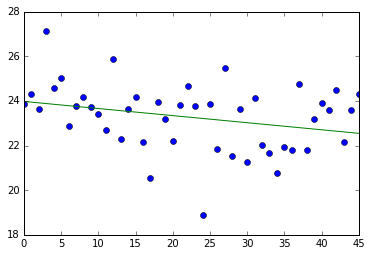

In [79]:
# Plot Mean Length of Utterance over time for RR
xs = dfRR['index']
ys = dfRR['MLU']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

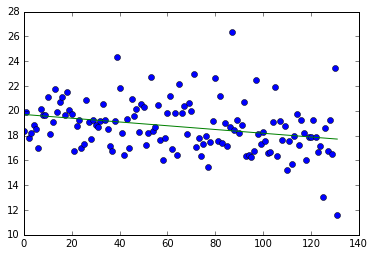

In [80]:
# Plot Mean Length of Utterance over time for GWHB
xs = dfGWHB['index']
ys = dfGWHB['MLU']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

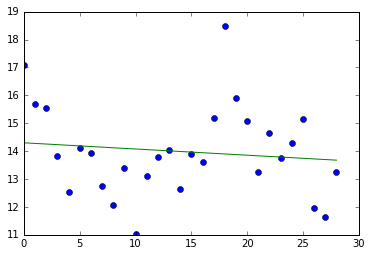

In [81]:
# Plot Mean Length of Utterance over time for DJT
xs = dfDJT['index']
ys = dfDJT['MLU']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

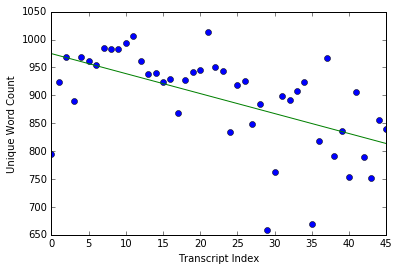

In [124]:
# Plot Unique Words over time for RR
xs = dfRR['index']
ys = dfRR['UniqueWords']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.xlabel('Transcript Index')
plt.ylabel('Unique Word Count')
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)
plt.savefig('RRUniqueWords.png')

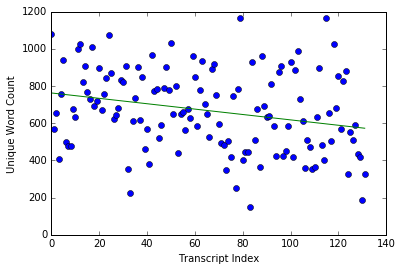

In [125]:
# Plot Unique Words over time for GWHB
xs = dfGWHB['index']
ys = dfGWHB['UniqueWords']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.xlabel('Transcript Index')
plt.ylabel('Unique Word Count')
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)
plt.savefig('GWHBUniqueWords.png')

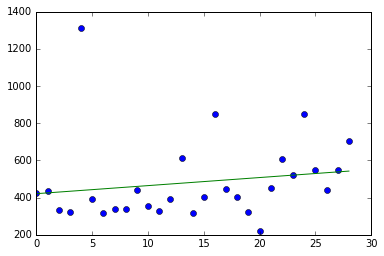

In [84]:
# Plot Unique Words over time for DJT
xs = dfDJT['index']
ys = dfDJT['UniqueWords']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

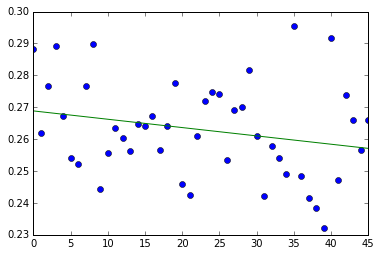

In [85]:
# Plot Token Type Ratio over time for RR
xs = dfRR['index']
ys = dfRR['TTR']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

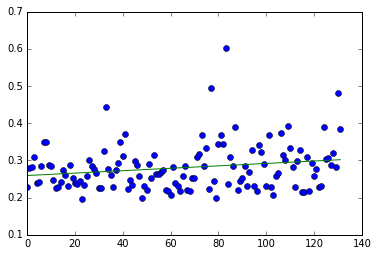

In [86]:
# Plot Token Type Ratio over time for GWHB
xs = dfGWHB['index']
ys = dfGWHB['TTR']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

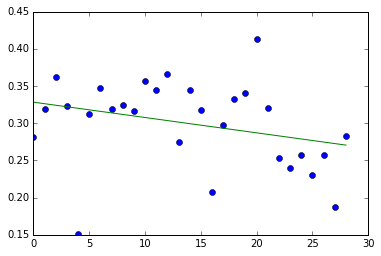

In [87]:
# Plot Token Type Ratio over time for DJT
xs = dfDJT['index']
ys = dfDJT['TTR']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

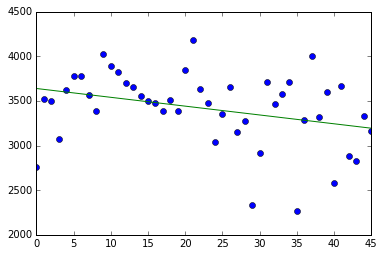

In [88]:
# Plot Word Count over time for RR
xs = dfRR['index']
ys = dfRR['WordCount']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

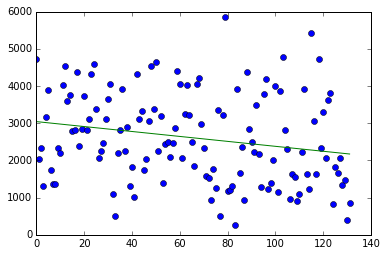

In [89]:
# Plot Word Count over time for GHWB
xs = dfGWHB['index']
ys = dfGWHB['WordCount']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

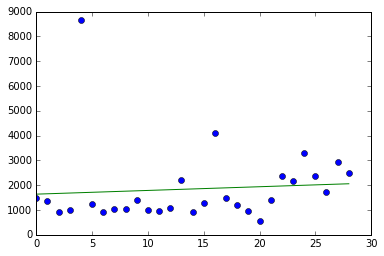

In [90]:
# Plot Word Count over time for DJT
xs = dfDJT['index']
ys = dfDJT['WordCount']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1)
plt.plot(xs, ys, 'o')
plt.plot(xs, trend[1] + trend[0] * xs)

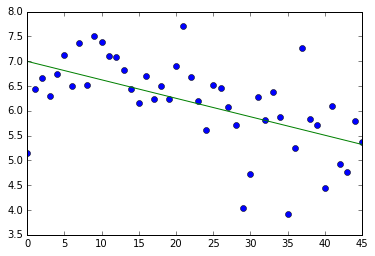

In [91]:
# Plot Nouns per 100 over time for RR
xs = dfRR['index']
ys = dfRR['Nouns/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

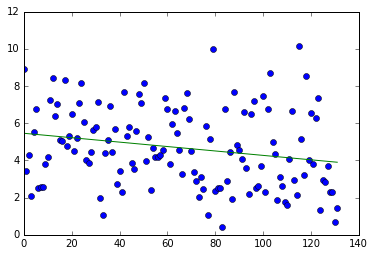

In [92]:
# Plot Nouns per 100 over time for GHWB
xs = dfGWHB['index']
ys = dfGWHB['Nouns/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

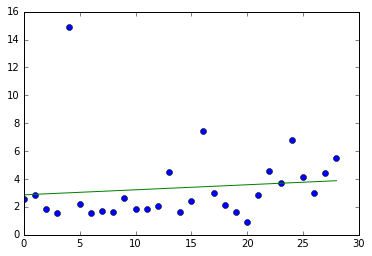

In [93]:
# Plot Nouns per 100 over time for DJT
xs = dfDJT['index']
ys = dfDJT['Nouns/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

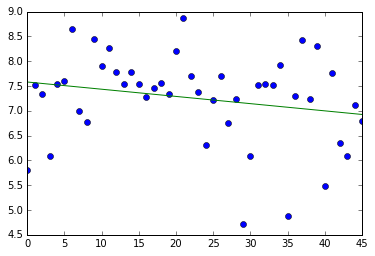

In [94]:
# Plot Verbs per 100 over time for RR
xs = dfRR['index']
ys = dfRR['Verbs/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

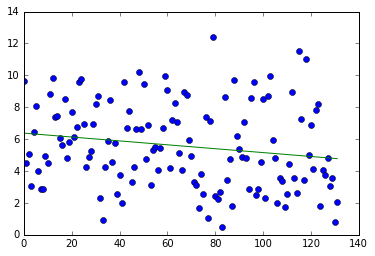

In [95]:
# Plot Verbs per 100 over time for GHWB
xs = dfGWHB['index']
ys = dfGWHB['Verbs/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

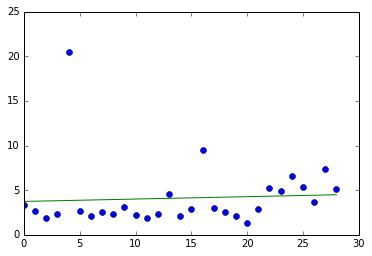

In [96]:
# Plot Verbs per 100 over time for DJT
xs = dfDJT['index']
ys = dfDJT['Verbs/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

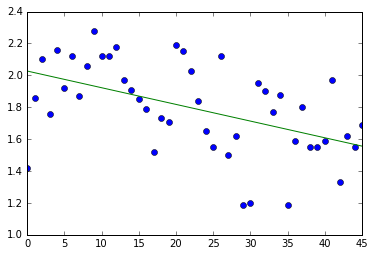

In [97]:
# Plot Adjectives per 100 over time for RR
xs = dfRR['index']
ys = dfRR['Adjectives/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

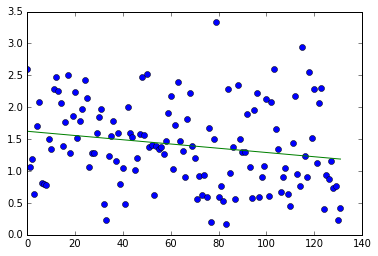

In [98]:
# Plot Adjectives per 100 over time for GHWB
xs = dfGWHB['index']
ys = dfGWHB['Adjectives/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

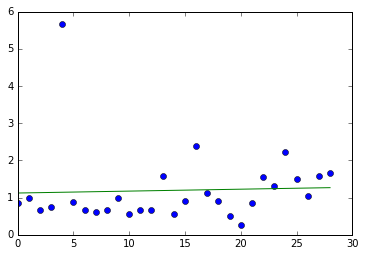

In [99]:
# Plot Adjectives per 100 over time for DJT
xs = dfDJT['index']
ys = dfDJT['Adjectives/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

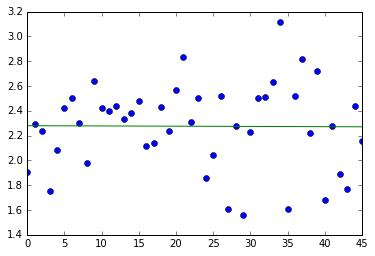

In [100]:
# Plot Adverbs per 100 over time for RR
xs = dfRR['index']
ys = dfRR['Adverbs/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

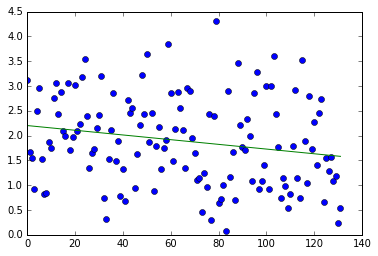

In [101]:
# Plot Adverbs per 100 over time for GHWB
xs = dfGWHB['index']
ys = dfGWHB['Adverbs/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

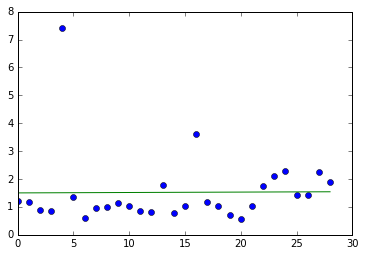

In [102]:
# Plot Adverbs per 100 over time for DJT
xs = dfDJT['index']
ys = dfDJT['Adverbs/100']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

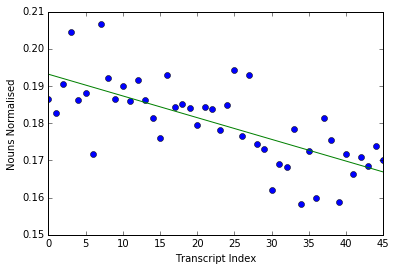

In [129]:
xs = dfRR['index']
ys = dfRR['NounsNormalised']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.xlabel('Transcript Index')
plt.ylabel('Nouns Normalised')
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)
plt.savefig('RRNounsNormalised.png')

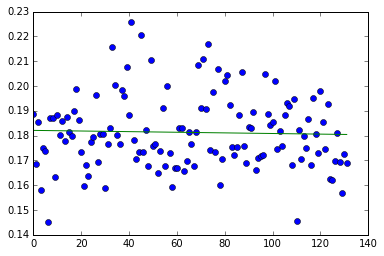

In [104]:
xs = dfGWHB['index']
ys = dfGWHB['NounsNormalised']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

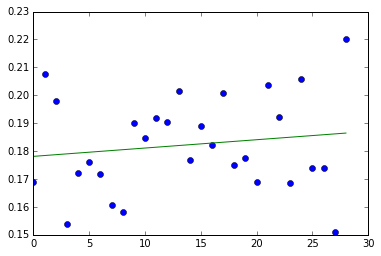

In [105]:
xs = dfDJT['index']
ys = dfDJT['NounsNormalised']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

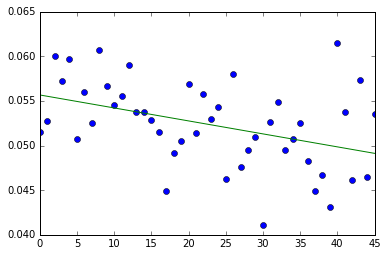

In [106]:
xs = dfRR['index']
ys = dfRR['AdjectivesNormalised']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

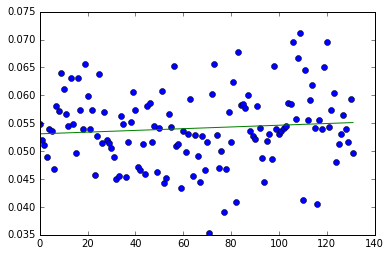

In [107]:
xs = dfGWHB['index']
ys = dfGWHB['AdjectivesNormalised']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

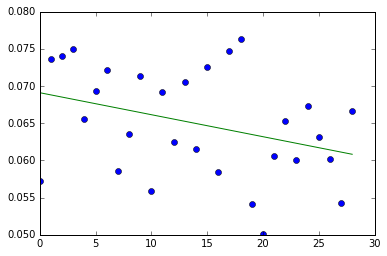

In [108]:
xs = dfDJT['index']
ys = dfDJT['AdjectivesNormalised']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

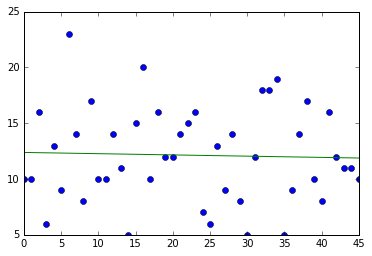

In [109]:
xs = dfRR['index']
ys = dfRR['Fillers']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

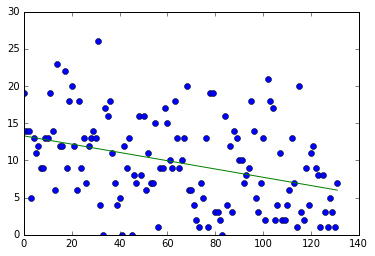

In [110]:
xs = dfGWHB['index']
ys = dfGWHB['Fillers']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

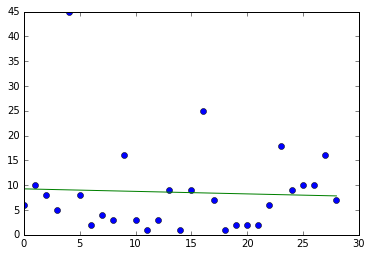

In [111]:
xs = dfDJT['index']
ys = dfDJT['Fillers']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

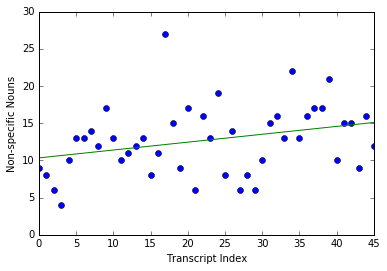

In [126]:
xs = dfRR['index']
ys = dfRR['NSNouns']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.xlabel('Transcript Index')
plt.ylabel('Non-specific Nouns')
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)
plt.savefig('RRNSNouns.png')

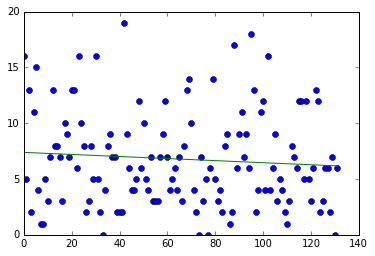

In [113]:
xs = dfGWHB['index']
ys = dfGWHB['NSNouns']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.xlabel('Transcript Index')
plt.ylabel('Non-specific Nouns')
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

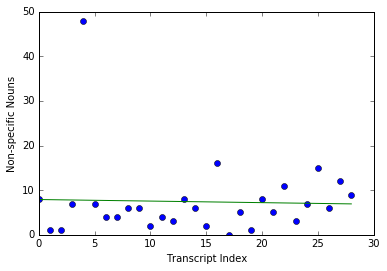

In [127]:
xs = dfDJT['index']
ys = dfDJT['NSNouns']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.xlabel('Transcript Index')
plt.ylabel('Non-specific Nouns')
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)
plt.savefig('DJTNSNouns.png')

In [ ]:
xs = dfRR['index']
ys = dfRR['LIVerbs']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

In [ ]:
xs = dfGWHB['index']
ys = dfGWHB['LIVerbs']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)

In [ ]:
xs = dfDJT['index']
ys = dfDJT['LIVerbs']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)


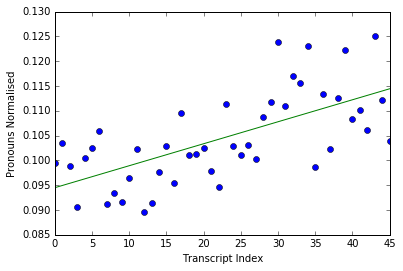

In [128]:
xs = dfRR['index']
ys = dfRR['PronounsNormalised']
xs = np.asarray(xs)
trend = np.polyfit(xs, ys, 1) # fit a straight line
plt.xlabel('Transcript Index')
plt.ylabel('Pronouns Normalised')
plt.plot(xs, ys,'o')
plt.plot(xs,trend[1]+trend[0]*xs)
plt.savefig('RRPronouns.png')

In [ ]:
labelsRR = dfRR['Filename']
dfRR = dfRR.drop(['Filename', 'JDate', 'Julian', 'Date', 'index'], axis=1)
labelsGHWB = dfGWHB['Filename']
dfGWHB = dfGWHB.drop(['Filename', 'JDate', 'Julian', 'Date', 'index'], axis=1)
labelsDJT = dfDJT['Filename']
dfDJT = dfDJT.drop(['Filename', 'JDate', 'Julian', 'Date', 'index'], axis=1)

In [ ]:
# Scale the data
yRRscaled = preprocessing.scale(yRR)
dfRRscaled = preprocessing.scale(dfRR)

yGWHBscaled = preprocessing.scale(yGWHB)
dfGWHBscaled = preprocessing.scale(dfGWHB)

yDJTscaled = preprocessing.scale(yDJT)
dfDJTscaled = preprocessing.scale(dfDJT)

-- LINEAR REGRESSION --

In [ ]:
resultsGridRR = pd.DataFrame()
for i in range (1,1000):
    X_train, X_test, y_train, y_test = train_test_split(dfRRscaled, yRR, test_size=0.20)
    # fit a model
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    predictions = lm.predict(X_test)
    slope, intercept, r_value, p_value, std_err = linregress(predictions, y_test)
    resultsTuple = {'Slope': slope, 'intercept': intercept, 'r_value': r_value,
                    'p_value':p_value, 
                    'std_err':std_err}
    resultsGridRR = resultsGridRR.append(resultsTuple, ignore_index=True)
    

In [ ]:
resultsGridGWHB = pd.DataFrame()
for i in range (1,1000):
    X_train, X_test, y_train, y_test = train_test_split(dfGWHBscaled, yGWHB, test_size=0.20)
    # fit a model
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    predictions = lm.predict(X_test)
    slope, intercept, r_value, p_value, std_err = linregress(predictions, y_test)
    resultsTuple = {'Slope': slope, 'intercept': intercept, 'r_value': r_value,
                    'p_value':p_value, 
                    'std_err':std_err}
    resultsGridGWHB = resultsGridGWHB.append(resultsTuple, ignore_index=True)

In [ ]:
resultsGridDJT = pd.DataFrame()
for i in range (1,1000):
    X_train, X_test, y_train, y_test = train_test_split(dfDJTscaled, yDJT, test_size=0.20)
    # fit a model
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    predictions = lm.predict(X_test)
    slope, intercept, r_value, p_value, std_err = linregress(predictions, y_test)
    resultsTuple = {'Slope': slope, 'intercept': intercept, 'r_value': r_value,
                    'p_value':p_value, 
                    'std_err':std_err}
    resultsGridDJT = resultsGridDJT.append(resultsTuple, ignore_index=True)

In [ ]:
resultsGridRR.describe()

In [ ]:
resultsGridGWHB.describe()

In [ ]:
resultsGridDJT.describe()

-- GAUSSIAN PROCESSES --

In [ ]:
path = '/home/CAMPUS/alcantaj/Dropbox/'
bush_df = pd.read_csv(path + 'Bush.csv')
reagan_df = pd.read_csv(path + 'Reagan.csv')

In [ ]:
minimum = reagan_df['Julian'].min() # Smallest Julian Date
maximum = reagan_df['Julian'].max() # Maximum Julian Date

In [ ]:
reagan_df['NormalisedDate'] = (reagan_df['Julian'] - minimum) / (maximum - minimum) 

In [ ]:
reagan_df['CountDays'] = reagan_df['Julian'] - minimum

In [ ]:
reagan_df['CountDaysN'] = reagan_df['CountDays'] / 365

In [ ]:
# NEED TO DROP DATA COLUMNS HERE BEFORE RUN MODEL
reagan_df = reagan_df.drop(['Unnamed: 0', 'Filename', 'index','Date', 'JDate', 'Julian',
                           'NormalisedDate', 'CountDays'], axis=1)

In [ ]:
target = reagan_df['CountDaysN']

In [ ]:
max_target = target.max()

In [ ]:
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(185, (1e-2, 1e4))
# kernel = RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=15)

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(reagan_df, target, test_size=0.20)

In [ ]:
target = np.asarray(y_train)
variables = np.asarray(X_train)

In [ ]:
# Fit to data using Maximum Likelihood Estimation of the parameters
model = gp.fit(variables, target) # This looks fine according to documentation

In [ ]:
y_pred, sigma = gp.predict(np.asarray(X_test), return_std=True)

In [ ]:
# The plot
plt.figure()
xs = [x for x in range(0, 9)]
ys = [x for x in range(0, 9)]
plt.plot(xs, ys)
plt.plot(y_test, y_pred, 'o', linestyle='None')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis(xscale = 0, yscale = 0)
plt.errorbar(y_test, y_pred, yerr=sigma, elinewidth=1, fillstyle='full', linestyle ='None')

In [ ]:
sqErr = (y_test - y_pred)**2

In [ ]:
df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred, 'sigma': sigma, 'Squared Error': sqErr})

In [ ]:
df

In [ ]:
MSE = sum(sqErr) / len(sqErr)

In [ ]:
MSE

In [ ]:
bush_df = pd.read_csv(path + 'Bush.csv')
reagan_df = pd.read_csv(path + 'Reagan.csv')

In [ ]:
minimum = reagan_df['Julian'].min() # Smallest Julian Date
maximum = reagan_df['Julian'].max() # Maximum Julian Date

In [ ]:
reagan_df['NormalisedDate'] = (reagan_df['Julian'] - minimum) / (maximum - minimum) 

In [ ]:
reagan_df['CountDays'] = reagan_df['Julian'] - minimum

In [ ]:
reagan_df['CountDaysN'] = reagan_df['CountDays'] / 365

In [ ]:
# NEED TO DROP DATA COLUMNS HERE BEFORE RUN MODEL
reagan_df = reagan_df.drop(['Unnamed: 0', 'Filename', 'index','Date', 'JDate', 'Julian',
                           'NormalisedDate', 'CountDays'], axis=1)

In [ ]:
target = reagan_df['CountDaysN']

In [ ]:
max_target = target.max()

In [ ]:
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(191, (1e-2, 1e4))
# kernel = RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=15)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reagan_df, target, test_size=0.20)

In [ ]:
Results = pd.DataFrame()
for i in range(0, 999):
    X_train, X_test, y_train, y_test = train_test_split(reagan_df, target, test_size=0.20)
    targetVar = np.asarray(y_train)
    variables = np.asarray(X_train)
    model = gp.fit(variables, targetVar)
    y_pred, sigma = gp.predict(np.asarray(X_test), return_std=True)
    sqErr = (y_test - y_pred)**2
    MSE = sum(sqErr)/len(sqErr)
    tuple = {'MSE': MSE, 'gp.kernel':gp.kernel, 'gp.kernel_':gp.kernel_}
    Results = Results.append(tuple, ignore_index = True)

In [ ]:
Mean = Results['MSE'].mean()
SD = Results['MSE'].std()

In [ ]:
print('The Mean is', Mean)
print('The SD is', SD)